# SC2008 LAB 4:  ANALZING NETWORK DATA LOG

## EXERCISE 4A: TOP TALKERS AND LISTENERS

In [9]:
!pip install ipwhois

In [10]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import plotly.express as px
from ipwhois import IPWhois


import warnings
warnings.filterwarnings('ignore')

In [11]:
# SFlow Format 
colName = ['Type', 'sflow_agent_address', 'inputPort', 'outputPort',
               'src_MAC', 'dst_MAC', 'ethernet_type', 'in_vlan', 'out_vlan',
               'src_IP', 'dst_IP', 'IP_protocol', 'ip_tos', 'ip_ttl',
               'src_transport_port', 'dst_transport_port', 'tcp_flags',
               'packet_size', 'IP_size', 'sampling_rate','variable']


In [12]:
df = pd.read_csv('Data_3.csv', names = colName)
df.drop('variable', axis=1, inplace = True)
df.head()


,Type,sflow_agent_address,inputPort,outputPort,src_MAC,dst_MAC,ethernet_type,in_vlan,out_vlan,src_IP,dst_IP,IP_protocol,ip_tos,ip_ttl,src_transport_port,dst_transport_port,tcp_flags,packet_size,IP_size,sampling_rate
0,FLOW,203.30.38.251,137,200,d404ff55fd4d,80711fc76001,0x0800,919,280,130.246.176.22,140.115.32.81,6,0x00,50,51216,23505,0x10,1518,1500,2048
1,FLOW,203.30.38.251,129,193,609c9f851b00,0031466b23cf,0x0800,11,919,155.69.160.32,64.233.188.128,6,0x00,56,23159,80,0x10,74,52,2048
2,FLOW,203.30.38.251,137,200,d404ff55fd4d,80711fc76001,0x0800,919,280,130.246.176.53,140.115.32.83,6,0x00,50,50041,20739,0x10,1518,1500,2048
3,FLOW,203.30.38.251,129,135,609c9f851b00,002688cd5fc7,0x0800,11,919,155.69.160.32,54.169.174.79,17,0x00,120,54241,26510,0x10,116,94,2048
4,FLOW,203.30.38.251,130,199,00239cd087c1,544b8cf9a7df,0x0800,919,600,137.132.228.15,193.62.192.8,6,0x00,56,53923,34262,0x10,70,52,2048


## Exercise 4A: Top talkers and listeners

### Top 5 Talkers

In [13]:
# Show top 5 source IP addresses
df['src_IP'].value_counts().head(5)

src_IP
193.62.192.8     3041
155.69.160.32    2975
130.14.250.11    2604
14.139.196.58    2452
140.112.8.139    2056
Name: count, dtype: int64

In [14]:
def find_org(ip_addr):
    ip = IPWhois(ip_addr)
    result = ip.lookup_rdap()
    return result.get('network', {}).get('name')

In [15]:
# Convert Src IP to list
top5_src_ip = list(df['src_IP'].value_counts().head(5).items())

# Create empty list to store organisation name
src_org = []

# Find org name
for ip,_ in top5_src_ip:
    src_org.append(find_org(ip))

In [16]:
top5_talkers = pd.DataFrame(top5_src_ip, columns= ['src_IP', 'No. of packets'])
top5_talkers['Organisation'] = src_org
top5_talkers

,src_IP,No. of packets,Organisation
0,193.62.192.8,3041,EUR-BIO-INST
1,155.69.160.32,2975,NTUNET1
2,130.14.250.11,2604,NLM-ETHER
3,14.139.196.58,2452,NKN-IIT-GUW
4,140.112.8.139,2056,T-NTU.EDU.TW-NET


### Top 5 Listeners

In [17]:
# Convert Dst IP to list
top5_dst_ip = list(df['dst_IP'].value_counts().head(5).items())

# Create empty list to store organisation name
dst_org = []

# Find org name
for ip,_ in top5_dst_ip:
    dst_org.append(find_org(ip))

top5_listeners = pd.DataFrame(top5_dst_ip, columns= ['dst_IP', 'No. of packets'])
top5_listeners['Organisation'] = dst_org
top5_listeners

,dst_IP,No. of packets,Organisation
0,103.37.198.100,3841,A-STAR-AS-AP
1,137.132.228.15,3715,NUSNET
2,202.21.159.244,2446,RPNET
3,192.101.107.153,2368,PNNL
4,103.21.126.2,2056,IITB-IN


## Exercise 4B: Transport Protocol

In [18]:
# Count all protocols
protocol_counts = df['IP_protocol'].value_counts()
protocol_counts

IP_protocol
6      56064
17      9462
50      1698
0       1261
47       657
41       104
1         74
381       45
58         4
103        1
Name: count, dtype: int64

In [19]:
# Get total number of packets
total = protocol_counts.sum()

# Extract TCP and UDP counts
tcp_count = protocol_counts.get(6)   # IP protocol number 6 = TCP
udp_count = protocol_counts.get(17)  # IP protocol number 17 = UDP

# Calculate percentages
tcp_percent = (tcp_count / total) * 100
udp_percent = (udp_count / total) * 100

# Turn into dataframe
transport_df = pd.DataFrame(data = [
    {'Protocol': 'TCP', 'Packets': tcp_count, 'Percentage': round(tcp_percent,3)},
    {'Protocol': 'UDP', 'Packets': udp_count, 'Percentage': round(udp_percent,3)}
])
transport_df

,Protocol,Packets,Percentage
0,TCP,56064,80.819
1,UDP,9462,13.640


## Exercise 4C: Application Protocol

In [20]:
df['dst_transport_port'].value_counts().head(5)


dst_transport_port
443      13423
80        2647
52866     2068
45512     1356
56152     1341
Name: count, dtype: int64

In [21]:
top5_dst_port= list(df['dst_transport_port'].value_counts().head(5).items())

In [22]:
port_map = {443: 'HTTPS',
            80: 'HTTP',
            52866: 'Dynamic/Private Ports',
            45512: 'Unassigned',
            56152: 'Dynamic/Private Ports',
            }

dst_port_df = pd.DataFrame(top5_dst_port, columns = ['dst_port','No. of packets'])
dst_port_df['Service'] = dst_port_df['dst_port'].map(port_map)

dst_port_df

,dst_port,No. of packets,Service
0,443,13423,HTTPS
1,80,2647,HTTP
2,52866,2068,Dynamic/Private Ports
3,45512,1356,Unassigned
4,56152,1341,Dynamic/Private Ports


## Exercise 4D: Traffic

In [23]:
# Calculate total traffic size in Megabytes (MB)

total_packet_size = df["IP_size"].sum() * 2048 / (1024*1024) 
print(f"Total traffic: {total_packet_size: .3f} MB")

Total traffic:  126519.184 MB


## Exercise 4E: Additional

### Top 5 Communication Pairs

In [24]:
pairs_df = df.groupby(['src_IP', 'dst_IP']).size().sort_values(ascending = False).to_frame()
pairs_df.columns = ['No. of Packets']
pairs_df = pairs_df.reset_index()

top5pairs_df = pairs_df[:5]
top5pairs_df

,src_IP,dst_IP,No. of Packets
0,193.62.192.8,137.132.228.15,3041
1,130.14.250.11,103.37.198.100,2599
2,14.139.196.58,192.101.107.153,2368
3,140.112.8.139,103.21.126.2,2056
4,137.132.228.15,193.62.192.8,1910


In [25]:

src_org = []
dst_org = []

for i in range(5):
    src_org.append(find_org(top5pairs_df['src_IP'][i]))
    dst_org.append(find_org(top5pairs_df['dst_IP'][i]))
    
top5pairs_df.loc[:, 'Source Organisation'] = src_org
top5pairs_df.loc[:, 'Destination Organisation'] = dst_org

top5pairs_df = top5pairs_df.reindex(['src_IP', 'Source Organisation', 'dst_IP', 
                                   'Destination Organisation', 
                                   'No. of Packets'], axis = 'columns')
top5pairs_df

,src_IP,Source Organisation,dst_IP,Destination Organisation,No. of Packets
0,193.62.192.8,EUR-BIO-INST,137.132.228.15,NUSNET,3041
1,130.14.250.11,NLM-ETHER,103.37.198.100,A-STAR-AS-AP,2599
2,14.139.196.58,NKN-IIT-GUW,192.101.107.153,PNNL,2368
3,140.112.8.139,T-NTU.EDU.TW-NET,103.21.126.2,IITB-IN,2056
4,137.132.228.15,NUSNET,193.62.192.8,EUR-BIO-INST,1910


## Visualing data


In [26]:
top50pairs_df = pairs_df[:50]

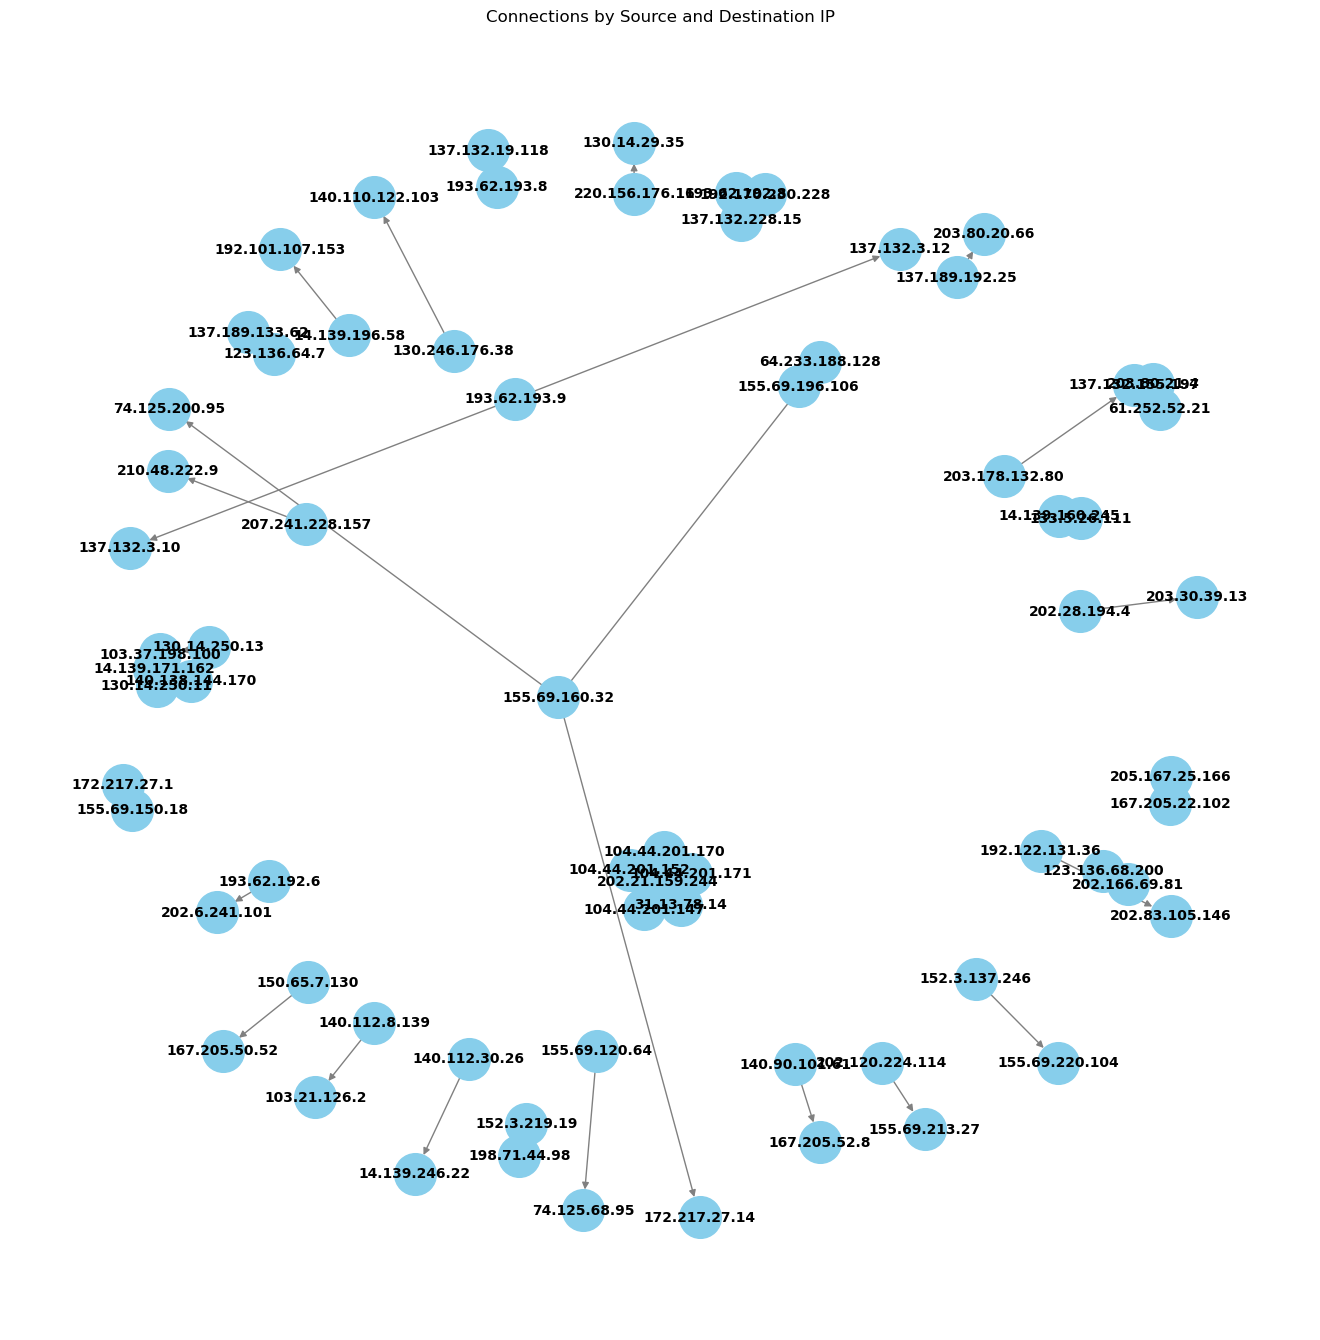

In [27]:
G=nx.from_pandas_edgelist(top50pairs_df,source="src_IP",target="dst_IP",create_using=nx.DiGraph())

plt.figure(figsize=(13,13))
pos =nx.spring_layout(G,seed=42)

nx.draw(G,pos,with_labels=True,node_size=900,node_color="skyblue",font_size=10,font_weight="bold",edge_color="gray",arrows=True)
plt.title("Connections by Source and Destination IP")
plt.show()